## 🧰 Step 1: Install Required Dependencies

We first install specific versions of key Python libraries to ensure compatibility with **PyMC 5.10.4**.  
This includes `scipy`, `numpy`, `arviz`, `pymc`, and others used for modeling and visualization.

In [1]:
!pip install "scipy<1.13" "numpy<2.0" "pymc==5.10.4" "arviz==0.15.1" pytensor matplotlib pandas --force-reinstall
!pip install --upgrade streamlit cachetools<6 packaging<25 pillow<11

  Using cached scipy-1.12.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (165 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached pymc-5.10.4-py3-none-any.whl.metadata (10 kB)
  Using cached arviz-0.15.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached pytensor-2.35.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached cachetools-6.2.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytensor-2.18.6-cp311-cp311-macosx_15_0_arm64.whl
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3

## 📊 Step 2: Generate Synthetic Data

We create a simulated dataset for a **hierarchical logistic regression** problem:
- There are multiple groups (e.g., 5 groups).
- Each observation has 2 features.
- The true coefficients (`true_beta`) and group-specific intercepts (`true_intercept`) generate the target variable `y` using a logistic function.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

np.random.seed(42)
num_groups = 5
n = 500

groups = np.random.randint(0, num_groups, n)
X = np.random.randn(n, 2)
true_intercept = np.random.normal(0, 1, num_groups)
true_beta = np.array([1.5, -2.0])

logit_p = true_intercept[groups] + X @ true_beta
p = 1 / (1 + np.exp(-logit_p))
y = np.random.binomial(1, p)

## 🧠 Step 3: Define Hierarchical Bayesian Logistic Regression Model

We define a **hierarchical Bayesian model** using PyMC:
- `mu_alpha` and `sigma_alpha` are hyperpriors controlling the distribution of group intercepts.
- Each group has its own intercept `alpha`.
- The regression coefficients `beta` are shared across groups.
- We model the binary target `y` using a **Bernoulli likelihood** with a logistic link.

We then sample from the posterior using NUTS (No-U-Turn Sampler).

In [3]:
with pm.Model() as hierarchical_model:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=num_groups)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    
    logits = alpha[groups] + pm.math.dot(X, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

print(az.summary(trace, var_names=["mu_alpha", "sigma_alpha", "beta"]))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha    -0.512  0.251  -1.008   -0.058      0.006    0.008    2011.0   
sigma_alpha  0.425  0.269   0.049    0.920      0.011    0.005     334.0   
beta[0]      1.482  0.173   1.139    1.782      0.004    0.003    1816.0   
beta[1]     -2.080  0.199  -2.446   -1.701      0.005    0.003    1717.0   

             ess_tail  r_hat  
mu_alpha       2031.0   1.01  
sigma_alpha     129.0   1.01  
beta[0]        2069.0   1.00  
beta[1]        1927.0   1.01  


## 📈 Step 4: Visualize Posterior and Perform Posterior Predictive Check

- Use `ArviZ` to visualize the trace and parameter distributions.
- Perform a **Posterior Predictive
-  Check (PPC)** to evaluate how well the model reproduces observed data.
- This helps confirm that the model fits the data reasonably well.

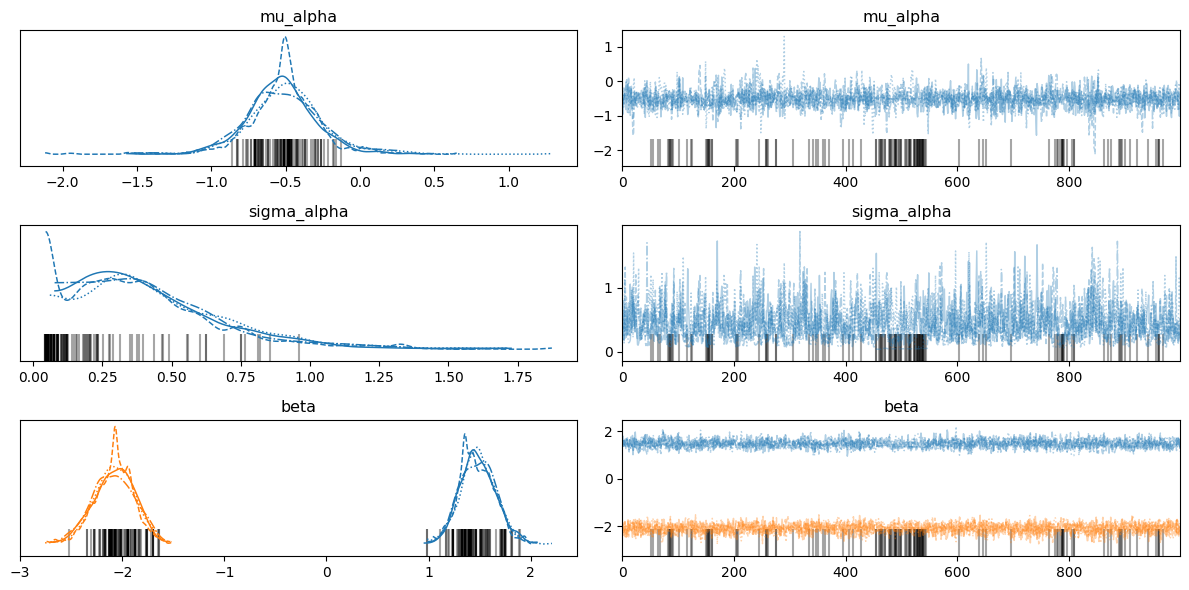

Sampling: [y_obs]


Output()

✅ Hierarchical Bayesian Logistic Regression ran successfully!


In [4]:
# Trace Plots
az.plot_trace(trace, var_names=["mu_alpha", "sigma_alpha", "beta"])
plt.tight_layout()
plt.show()

# Posterior Predictive Check
with hierarchical_model:
    idata_pp = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=42)

az.plot_ppc(idata_pp)
plt.show()

print("✅ Hierarchical Bayesian Logistic Regression ran successfully!")